# 1.0 Imports

In [62]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# 2.0 Read CSV
**Nesta etapa, o arquivo csv é lido e atribuido à classe pandas. Também utilizo a função head() para me ajudar a enxergar como os dados estão dispostos, com isso posso gerar ideias de como fazer a próxima etapa.**

In [63]:
dir_path = os.path.dirname(os.path.abspath(''))
csv_path = os.path.join(dir_path,'dataset','teste_indicium_precificacao.csv')
data_frame = pd.read_csv(csv_path)
data_frame.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


# 3.0 Functions

In [90]:
def outliers_identification(df, coluna):
    """
        função que recebe uma coluna no formato string e retorna um dataframe com duas colunas, 
        uma contendo os outliers inferiores e a outra os inferiores
    """
    quartil_1 = df[coluna].quantile(0.25)
    quartil_2 = df[coluna].quantile(0.50)
    quartil_3 = df[coluna].quantile(0.75)
    intervalo_interquartil = quartil_3 - quartil_1
    limite_superior = quartil_3 + 1.5*intervalo_interquartil
    limite_inferior = quartil_1 - 1.5*intervalo_interquartil
    outliers = pd.DataFrame(columns=['inferior_outliers','superior_outliers'])
    outliers['inferior_outliers'] = df[df[coluna] < limite_inferior][coluna]
    outliers['superior_outliers'] = df[df[coluna] > limite_superior][coluna]
    return outliers

# 4.0 Data Processing
**Após um vislumbre inicial dos dados, é importante aprofundar o exame para obter informações mais detalhadas sobre o DataFrame.**

**Ao examinar a quantidade de linhas, identificar valores ausentes e verificar os tipos de dados em cada coluna, consigo extrair insights valiosos que orientam as próximas etapas de limpeza e preparação dos dados.**

**É evidente que as colunas do dataframe não estão padronizadas, algumas com nome em inglês outras em português. Também é interessante organizar para que tudo fique padronizado, como a base de dados é de estabelecimentos de Nova York vou deixá-los todos em Inglês.**

**Também é interessante criar um nova coluna contendo o preço mínimo de hospedagem visto que há uma tabela de preço e outra de estadia mínima**

In [64]:
# print para saber as informações do data frame
print(data_frame.info())

# padronização dos nomes das colunas
# criação de um dict com a troca de nomes das colunas
colunas_renomeadas = {'nome':'name',
                      'bairro_group':'district',
                      'bairro':'neighborhood',
                      'minimo_noites':'minimum_nights',
                      'numero_de_reviews':'reviews_count',
                      'ultima_review':'last_review',
                      'reviews_por_mes':'monthly_reviews',
                      'calculado_host_listings_count':'calculated_host_listings_count',
                      'disponibilidade_365':'yearly_availability'}

data_frame.rename(columns=colunas_renomeadas, inplace=True)

# eliminação de valores vazios das colunas identificadas
for coluna in ['name', 'host_name', 'last_review', 'monthly_reviews']:
    data_frame.dropna(subset=[coluna], inplace=True)

# transformar coluna last_review em date time
data_frame['last_review'] = pd.to_datetime(data_frame['last_review'], format='%Y-%m-%d')

# criação de uma coluna chamada preço total que é o price multiplicado pela quantidade mínima de noites
data_frame['total_price'] = data_frame['price']*data_frame['minimum_nights']




# info do data frame após todos os processos
print(data_frame.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

# 5.0 Análises
**Esta etapa tem como intuito levantamento e validação de hipóteses**

## 5.1 Identificação de Hotéis 'Bons' e seus Outliers
**Considerando que hotéis bons são aqueles com pouca disponibilidade anual, tendo em vista que pela falta de agenda, muitas pessoas estão alugando, e uma quantidade de reviews significativa, nesta célula dedico um tempo para ir mais a fundo na coluna reviews_count.**

    Para não utilizar números arbitrários para a consideração positiva de hotéis, resolvi usar a média da quantidade de reviews e disponibilidade anual. Portanto, hotéis que apresentam disponibilidade abaixo da média e um número de reviews acima da média são considerados bons.

**Ao pegar o valor mínimo da coluna de reviews_count, é possível afirmar que houve ou não erro na inserção destes dados. Caso haja valores negativos, é logicamente errado existir um estabelecimento com quantidade de reviews negativa e sabendo disso providências serão tomadas. Para este caso não houve valores negativos**


Quantidade mínima de reviews: 1
Média do número de reviews: 29.29
Mediana: 9.0
Percentual de outliers superior: 6.20%


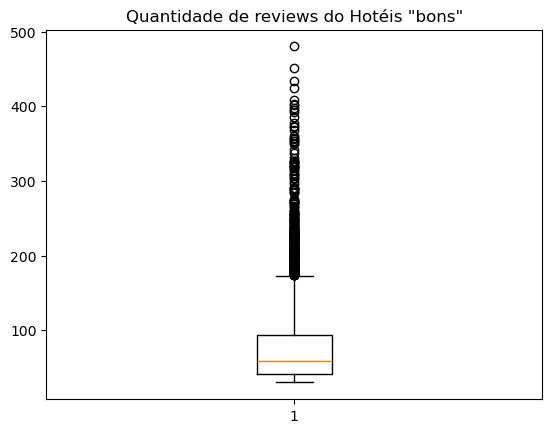

,name,price,minimum_nights,reviews_count,yearly_availability
5,BlissArtsSpace!,60,45,49,0
7,Cozy Clean Guest Room - Family Apt,79,2,118,0
9,Beautiful 1br on Upper West Side,135,5,53,6
10,Central Manhattan/near Broadway,85,2,188,39
14,Only 2 stops to Manhattan studio,140,2,148,46
...,...,...,...,...,...
42664,Queens Studio.,55,2,37,6
42941,Lucio's Room #3 a unos minutos del JFK y LGA,75,1,31,89
43138,Comfortable Room with Private Bath - 15 min to...,50,1,34,61
43790,NYC High End Upper East Side Central Park Gem ...,151,1,30,42


In [99]:
# mínimo, média e mediana da reviews_count. O mínimo aponta se há erro na inserção, caso haja valor negativo.
minimo_numero_reviews = data_frame['reviews_count'].min()
media_numero_reviews = data_frame['reviews_count'].mean()
mediana_numero_review = data_frame['reviews_count'].median()

media_disponibilidade = data_frame['yearly_availability'].mean()
print(f'Quantidade mínima de reviews: {minimo_numero_reviews}\nMédia do número de reviews: {media_numero_reviews:.2f}\nMediana: {mediana_numero_review}')

df_disponibilidade_abaixo_media = data_frame[data_frame['yearly_availability'] < media_disponibilidade]

df_lugares_bons_de_alugar = df_disponibilidade_abaixo_media[df_disponibilidade_abaixo_media['reviews_count'] > media_numero_reviews]
df_lugares_bons_de_alugar = df_lugares_bons_de_alugar[['name','price','minimum_nights','reviews_count','yearly_availability']]

# identificando outliers
df = outliers_identification(df_lugares_bons_de_alugar,'reviews_count')
quantidade_de_outliers_superior = df['superior_outliers'].shape[0]
quantidade_total_de_dados = df_lugares_bons_de_alugar['reviews_count'].shape[0]
percentual_de_outliers_superior = (quantidade_de_outliers_superior/quantidade_total_de_dados)*100
print(f'Percentual de outliers superior: {percentual_de_outliers_superior:.2f}%')

plt.boxplot(df_lugares_bons_de_alugar['reviews_count'])
plt.title('Quantidade de reviews do Hotéis "bons"')
plt.show()

df_lugares_bons_de_alugar

In [47]:
organizado = np.sort(data_frame['reviews_count'].unique())
print(organizado)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

In [38]:
maximo = data_frame['yearly_availability'].max()
minimo = data_frame['yearly_availability'].min()
print(f'maximo: {maximo}\nminimo: {minimo}')

maximo: 365
minimo: 0
